In [45]:
#import library
import pandas as pd
import numpy as np
np.random.seed(42)
import random
random.seed(42)
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV ,StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder ,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import joblib
import gradio as gr
import warnings
warnings.filterwarnings("ignore")

In [46]:
stress = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv") 

# Transform Stress_level to categorical variable
def stress_cat(stress):
    conditions = [
        (stress['Stress Level'] >= 0) & (stress['Stress Level'] <= 3),
        (stress['Stress Level'] > 3) & (stress['Stress Level'] <= 6),
        (stress['Stress Level'] > 6) & (stress['Stress Level'] <= 10)
    ]
    choices = ['Low', 'Medium', 'High']
    stress['Stress_Category'] = np.select(conditions, choices, default='Unknown')
    return stress
stress = stress_cat(stress)

stress.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder,Stress_Category
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN,Medium
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN,High
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN,High
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,High
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,High


In [47]:
# Display the data types, non-null counts, and memory usage.
stress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
 13  Stress_Category          374 non-null    object 
dtypes: float64(1), int64(7), o

In [48]:
stress.shape

(374, 14)

In [49]:
# Checking the null values
stress.isnull().sum()

Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
Stress_Category              0
dtype: int64

In [50]:
# Handle missing values
stress['Sleep Disorder'].fillna('Nothing', inplace=True)
stress.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder,Stress_Category
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,Nothing,Medium
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,Nothing,High
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,Nothing,High
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,High
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,High


In [51]:
stress["BMI Category"].value_counts()

BMI Category
Normal           195
Overweight       148
Normal Weight     21
Obese             10
Name: count, dtype: int64

In [52]:
stress['BMI Category'] = stress['BMI Category'].replace({'Normal Weight': 'Normal'})

In [53]:
duplicate_rows = stress[stress.duplicated()]

print("Duplicate Rows:")
print(duplicate_rows)

Duplicate Rows:
Empty DataFrame
Columns: [Person ID, Gender, Age, Occupation, Sleep Duration, Quality of Sleep, Physical Activity Level, Stress Level, BMI Category, Blood Pressure, Heart Rate, Daily Steps, Sleep Disorder, Stress_Category]
Index: []


In [54]:
stress.nunique().to_frame('unique count').T

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder,Stress_Category
unique count,374,2,31,11,27,6,16,6,3,25,19,20,3,3


In [55]:
stress['Occupation'].unique()

array(['Software Engineer', 'Doctor', 'Sales Representative', 'Teacher',
       'Nurse', 'Engineer', 'Accountant', 'Scientist', 'Lawyer',
       'Salesperson', 'Manager'], dtype=object)

In [56]:
stress['Sleep Disorder'].unique()

array(['Nothing', 'Sleep Apnea', 'Insomnia'], dtype=object)

In [57]:
stress['BMI Category'].unique()

array(['Overweight', 'Normal', 'Obese'], dtype=object)

In [58]:
# Feature Engineering
stress[['Systolic BP', 'Diastolic BP']] = stress['Blood Pressure'].str.split('/', expand=True).astype(int)
stress['BP_Ratio'] = stress['Diastolic BP'] / stress['Systolic BP']
stress['Age_Group'] = pd.cut(stress['Age'], bins=[18,30,45,60,100], labels=['Young','Adult','Mid-Age','Senior'])

In [59]:
stress.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder,Stress_Category,Systolic BP,Diastolic BP,BP_Ratio,Age_Group
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,Nothing,Medium,126,83,0.658730,Young
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,Nothing,High,125,80,0.640000,Young
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,Nothing,High,125,80,0.640000,Young
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,High,140,90,0.642857,Young
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,High,140,90,0.642857,Young


In [60]:
stress['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [61]:
# Drop unnecessary columns
stress.drop(['Person ID', 'Blood Pressure', 'Physical Activity Level'], axis=1, inplace=True)

In [62]:
# 1. Initial Data Prep (no transforms)
X = stress.drop('Stress Level', axis=1)
y = stress['Stress Level']

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)



In [63]:
# 3. Define Feature Types
numeric_features = ['Age', 'Sleep Duration','Quality of Sleep','Heart Rate',
                    'Daily Steps','Systolic BP', 'Diastolic BP', 'BP_Ratio']

ordinal_features = ['BMI Category', 'Age_Group'] 
nominal_features = ['Gender','Occupation']

In [64]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('ord', OrdinalEncoder(categories=[
            ['Overweight', 'Normal', 'Obese'],  # BMI Category
            ['Young','Adult','Mid-Age','Senior']   # Age_Group
        ]), ordinal_features),
        ('nom', OneHotEncoder(handle_unknown='ignore'), nominal_features)
    ],
    remainder='drop'  
)


In [65]:
# 5. Process Data
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)  

In [66]:
X_train_process=pd.DataFrame(X_train_proc)
X_train_process

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,-1.428347,0.696882,-0.270669,-0.064277,0.712017,-1.103254,-0.751719,0.672146,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.312952,-1.307859,-1.104999,0.410265,-1.110698,-0.460978,-0.751719,-1.404780,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.735979,0.070401,0.563661,-0.538820,0.104445,-1.745530,-1.556748,-0.456618,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.620584,0.822178,0.563661,-0.538820,0.104445,-1.103254,-0.751719,0.672146,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.043611,-0.430785,-1.104999,1.833893,-1.110698,0.181298,0.053310,-0.326376,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,-0.505190,-0.054896,0.563661,-0.538820,0.712017,0.181298,0.053310,-0.326376,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295,-1.197558,-1.433155,-1.104999,0.410265,-1.110698,-0.460978,-0.751719,-1.404780,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296,1.687310,1.323363,1.397991,-0.538820,0.104445,1.465850,1.663367,1.599344,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
297,-1.428347,0.947475,-0.270669,-0.064277,0.712017,-1.103254,-0.751719,0.672146,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# Handle Class Imbalance (ONLY on training)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_proc, y_train)

In [68]:
unique_values, counts = np.unique(y_train_res, return_counts=True)
print(dict(zip(unique_values, counts)))

{np.int64(3): np.int64(57), np.int64(4): np.int64(57), np.int64(5): np.int64(57), np.int64(6): np.int64(57), np.int64(7): np.int64(57), np.int64(8): np.int64(57)}


In [69]:
#  Hyperparameter Tuning
param_grid = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20],
    'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__min_samples_leaf': [1, 2]
}

In [70]:
# Model Training and Evaluation
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(
    random_state=42,  
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)
# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


In [71]:
# Set up cross-validation with fixed randomness
cv = StratifiedKFold(
    n_splits=5,       # 5-fold cross-validation
    shuffle=True,     # Shuffle the data before splitting
    random_state=42   # Fixes the randomness in data splitting
)

In [72]:
# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=cv,            
    scoring='accuracy',
    n_jobs=-1,        
    verbose=1         
)


In [73]:
# Fit the model
print("Starting Grid Search...")
grid_search.fit(X_train_res, y_train_res)

Starting Grid Search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], 'n_estimators': [100, 200]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [74]:
# Get best model
best_rf = grid_search.best_estimator_
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best Validation Accuracy: {grid_search.best_score_:.2f}")


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Validation Accuracy: 0.97


In [75]:
# Evaluate on test set
y_pred = best_rf.predict(X_test_proc)

# Model Evaluation Metrics
print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Test Set Evaluation:
Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00         9
           7       1.00      0.90      0.95        10
           8       0.93      1.00      0.97        14

    accuracy                           0.99        75
   macro avg       0.99      0.98      0.99        75
weighted avg       0.99      0.99      0.99        75



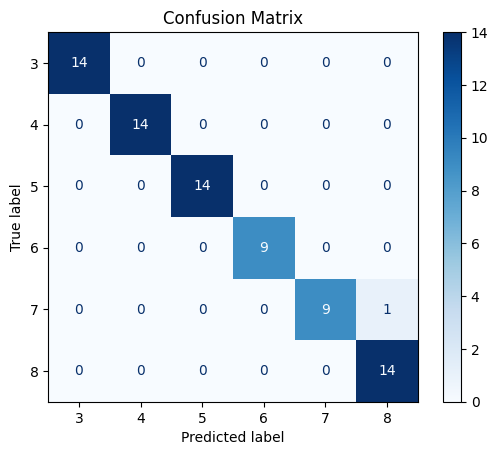

In [76]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                            display_labels=best_rf.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [77]:
# Feature Importance Analysis
# Get feature names after preprocessing
numeric_feature_names = numeric_features
ordinal_feature_names = ordinal_features

In [78]:
# Get OneHot encoded feature names
ohe = preprocessor.named_transformers_['nom']
nominal_feature_names = ohe.get_feature_names_out(nominal_features)
all_feature_names = numeric_feature_names + ordinal_feature_names + list(nominal_feature_names)

In [79]:
print(all_feature_names)

['Age', 'Sleep Duration', 'Quality of Sleep', 'Heart Rate', 'Daily Steps', 'Systolic BP', 'Diastolic BP', 'BP_Ratio', 'BMI Category', 'Age_Group', 'Gender_Female', 'Gender_Male', 'Occupation_Accountant', 'Occupation_Doctor', 'Occupation_Engineer', 'Occupation_Lawyer', 'Occupation_Manager', 'Occupation_Nurse', 'Occupation_Sales Representative', 'Occupation_Salesperson', 'Occupation_Scientist', 'Occupation_Software Engineer', 'Occupation_Teacher']


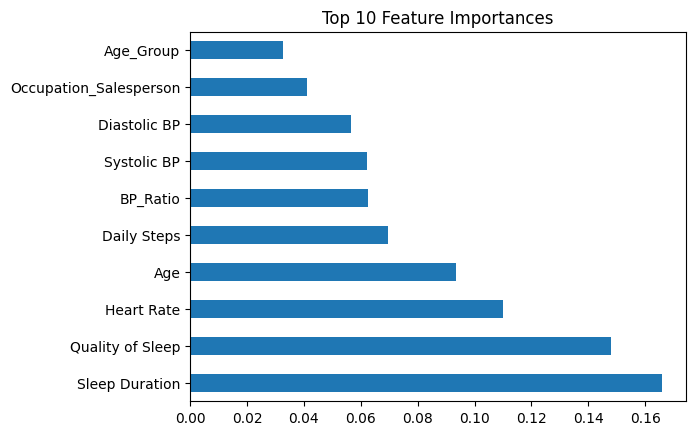

In [80]:
# Plot feature importances
importances = best_rf.feature_importances_
feat_importances = pd.Series(importances, index=all_feature_names)
feat_importances.nlargest(10).plot(kind='barh', title='Top 10 Feature Importances')
plt.show()

In [81]:
#  Model Saving
joblib.dump(preprocessor, 'preprocessor.pkl')
joblib.dump(best_rf, 'stress_predictor.pkl')

['stress_predictor.pkl']

In [82]:
# Prediction Function
def predict_stress_level():
    try:
        # Load saved components
        preprocessor = joblib.load('preprocessor.pkl')
        model = joblib.load('stress_predictor.pkl')
        
        print("Enter the following details:")
        inputs = {
            'Gender': input("Gender (Male/Female): "),
            'Age': int(input("Age: ")),
            'Occupation': input("Occupation: "),
            'Sleep Duration': float(input("Sleep Duration (hours): ")),
            'Quality of Sleep': int(input("Sleep Quality (1-10): ")),
            'BMI Category': input("BMI Category (Underweight/Normal/Overweight/Obese): "),
            'Heart Rate': int(input("Heart Rate (bpm): ")),
            'Daily Steps': int(input("Daily Steps: ")),
            'Systolic BP': int(input("Systolic BP: ")),
            'Diastolic BP': int(input("Diastolic BP: "))
        }
        
        # Create DataFrame
        input_df = pd.DataFrame([inputs])
        
        # Calculate derived features
        input_df['BP_Ratio'] = input_df['Diastolic BP'] / input_df['Systolic BP']
        input_df['Age_Group'] = pd.cut(input_df['Age'], 
                                     bins=[18,30,45,60,100],
                                     labels=['Young','Adult','Mid-Age','Senior'])
        
        # Preprocess and predict
        processed_input = preprocessor.transform(input_df)
        prediction = model.predict(processed_input)
        
        print(f"\nPredicted Stress Level: {prediction[0]}")
        
    except Exception as e:
        print(f"\nError occurred: {str(e)}")
        print("Please check your input values and try again.")


In [ ]:
# Save model training pipeline to a file
import joblib
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

# Definisikan Kolom (Sesuai dataset kamu)
num_cols = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Heart Rate', 
            'Daily Steps', 'Systolic BP', 'Diastolic BP', 'BP_Ratio']
ord_cols = ['BMI Category', 'Age_Group']
nom_cols = ['Gender', 'Occupation', 'Sleep Disorder']

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('ord', OrdinalEncoder(), ord_cols),
        ('nom', OneHotEncoder(handle_unknown='ignore'), nom_cols)
    ])

# Pipeline (Preprocessor + Model)
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Latih Ulang Model
model_pipeline.fit(X, y)

joblib.dump(model_pipeline, 'stress_predictor_model.pkl')


Model berhasil disimpan! Cek folder kamu ada file 'stress_predictor_model.pkl'


In [ ]:
# pip install gradio
# # Load model
# preprocessor = joblib.load('preprocessor.pkl')
# model = joblib.load('stress_predictor.pkl')

# def predict(gender, age, occupation, sleep_duration, sleep_quality, 
#             bmi_category, heart_rate, daily_steps, systolic_bp, diastolic_bp):
#     input_data = {
#         'Gender': gender.capitalize(),
#         'Age': age,
#         'Occupation': occupation,
#         'Sleep Duration': sleep_duration,
#         'Quality of Sleep': sleep_quality,
#         'BMI Category': bmi_category.capitalize(),
#         'Heart Rate': heart_rate,
#         'Daily Steps': daily_steps,
#         'Systolic BP': systolic_bp,
#         'Diastolic BP': diastolic_bp
#     }
    
#     input_df = pd.DataFrame([input_data])
#     input_df['BP_Ratio'] = input_df['Diastolic BP'] / input_df['Systolic BP']
#     input_df['Age_Group'] = pd.cut(input_df['Age'], 
#                                  bins=[18,30,45,60,100],
#                                  labels=['Young','Adult','Mid-Age','Senior'])
    
#     processed_input = preprocessor.transform(input_df)
#     prediction = model.predict(processed_input)
    
#     return int(prediction[0])

# iface = gr.Interface(
#     fn=predict,
#     inputs=[
#         gr.Dropdown(["Male", "Female"], label="Gender"),
#         gr.Number(label="Age"),
#         gr.Textbox(label="Occupation"),
#         gr.Number(label="Sleep Duration (hours)"),
#         gr.Slider(1, 10, step=1, label="Sleep Quality (1-10)"),
#         gr.Dropdown(["Normal", "Overweight", "Obese"], label="BMI Category"),
#         gr.Number(label="Heart Rate (bpm)"),
#         gr.Number(label="Daily Steps"),
#         gr.Number(label="Systolic BP"),
#         gr.Number(label="Diastolic BP")
#     ],
#     outputs="number",
#     title="Stress Level Predictor",
#     description="Enter your health metrics to predict your stress level (0-10)"
# )

# iface.launch()